In [3]:
import pandas as pd
import numpy as np
from numpy import mean

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

from matplotlib import pyplot as plt

#import warnings

#warnings.filterwarnings('ignore')

(1797, 64)


<Figure size 432x288 with 0 Axes>

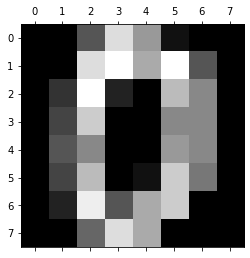

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()

# Preprocessing

In [5]:
xData = digits.data
yData = digits.target

In [6]:
yData

array([0, 1, 2, ..., 8, 9, 8])

In [7]:
xData

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [8]:
xData.shape, yData.shape

((1797, 64), (1797,))

In [9]:
# Split data into train and test
train_x, test_x, train_y, test_y = train_test_split(xData, yData, test_size=0.2, shuffle=True)

In [10]:
# Create a function to save results
import json

def save_results(results, filename):
    with open(filename + '.json', 'w') as fp:
        json.dump(results, fp)
        
        
def load_results(file_name):
    with open(file_name) as f:
        temp_results = json.load(f)
    return temp_results

# Decision Trees
Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

In a Decision tree, there are two nodes, which are the Decision Node and Leaf Node. Decision nodes are used to make any decision and have multiple branches, whereas Leaf nodes are the output of those decisions and do not contain any further branches.

In [18]:
data = digits.copy()

In [91]:
### Evaluate model without any pruning
# Train model
model = DecisionTreeClassifier()
model = model.fit(train_x, train_y)

# Evaluate performance
train_accuracy = model.score(train_x, train_y)
test_accuracy = model.score(test_x, test_y)

print('Training accuracy: ' + str(train_accuracy))
print('Test accuracy: ' + str(test_accuracy))

Training accuracy: 1.0
Test accuracy: 0.8611111111111112


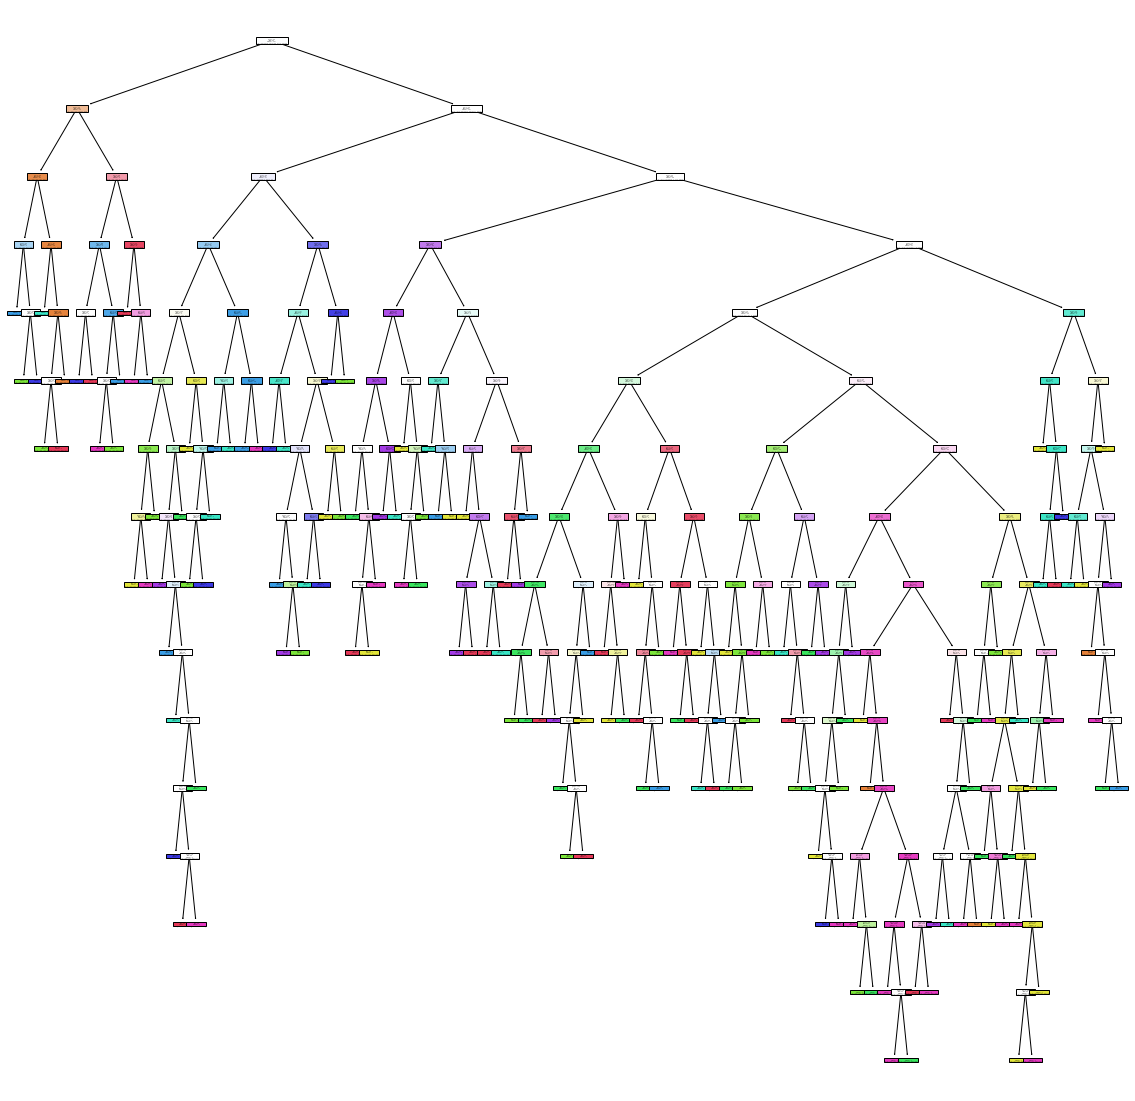

In [34]:
# visualiza the tree
from sklearn import tree
plt.figure(figsize=(20,20))
tree.plot_tree(model,filled=True)
plt.show()

In [92]:
# Initialize model
model = DecisionTreeClassifier()

# Compute path for pruning
path = model.cost_complexity_pruning_path(train_x, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

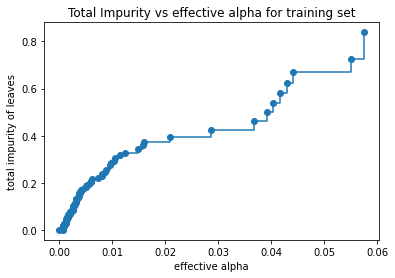

In [93]:
# the maximum effective alpha value is removed, because it is the trivial tree with only one node.
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [94]:
# we train a decision tree using the effective alphas. 
# The last value in ccp_alphas is the alpha value that prunes the whole tree, 
# leaving the tree, clfs[-1], with one node.
# For each alpha we will append our model to a list

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_x, train_y)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06057171429574526


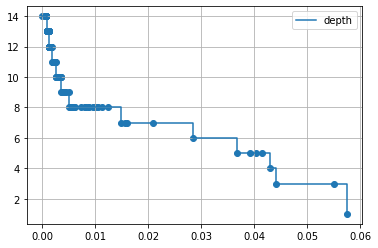

In [95]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
#plt.set_xlabel("alpha")
#plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
#plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.grid()
plt.legend()
plt.show()


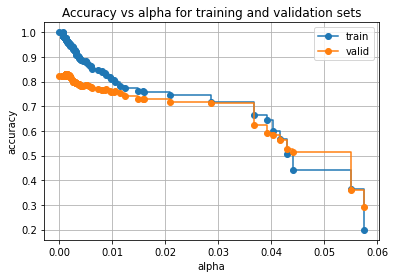

In [96]:
train_scores = [clf.score(train_x, train_y) for clf in clfs]
#test_scores = [clf.score(test_x, test_y) for clf in clfs]
cv_scores = [cross_val_score(clf, xData, yData, cv=10).mean() for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, cv_scores, marker="o", label="valid", drawstyle="steps-post")
ax.legend()
plt.grid()
plt.show()

In [97]:
max_index = np.argmax(cv_scores)

print('Optimized alpha: ' + str(ccp_alphas[max_index]))
print('Training accuracy: ' + str(round(train_scores[max_index]*100, 5)) + '%')
print('Valid accuracy: ' + str(round(cv_scores[max_index]*100, 5)) + '%')

Optimized alpha: 0.0012526096033402922
Training accuracy: 97.21642%
Valid accuracy: 82.96989%


0.01197361946105957


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



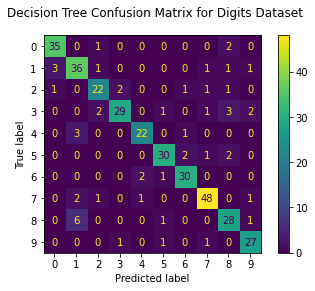

In [98]:
import time
s = time.time()
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[max_index])
clf.fit(train_x, train_y)
e = time.time()
print(e-s)


fig = plot_confusion_matrix(clf, test_x, test_y, display_labels=clf.classes_)
fig.figure_.suptitle("Decision Tree Confusion Matrix for Digits Dataset")
plt.show()

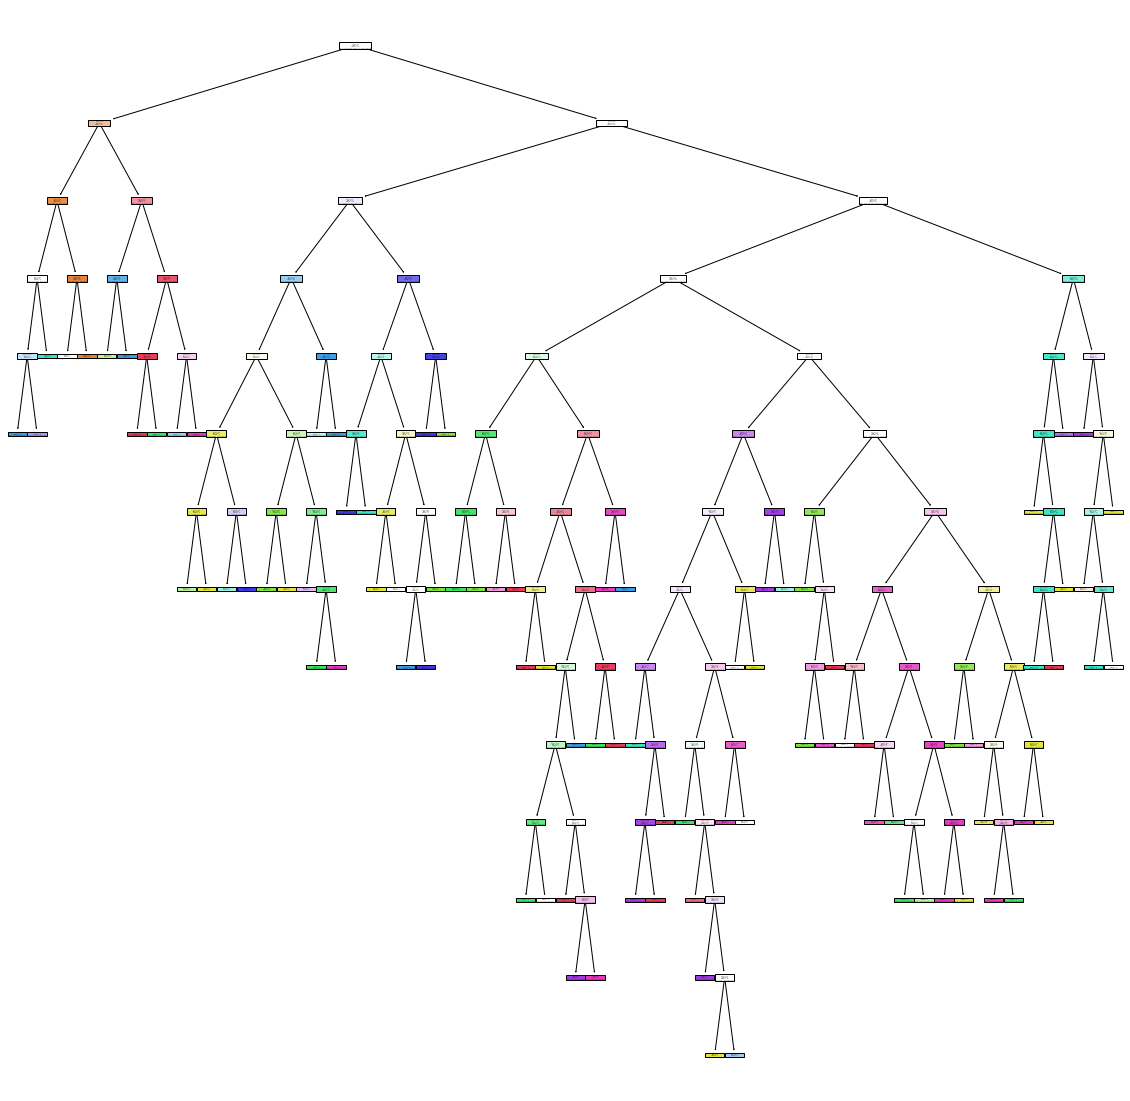

In [102]:
from sklearn import tree
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[max_index])
plt.figure(figsize=(20,20))
clf.fit(train_x, train_y)
tree.plot_tree(clf,filled=True)
plt.show()

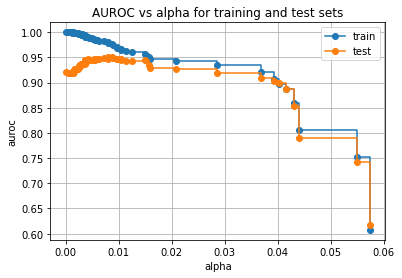

In [104]:
from sklearn.metrics import roc_auc_score
train_auroc = [roc_auc_score(train_y, clf.predict_proba(train_x), multi_class='ovr') for clf in clfs]
test_auroc = [roc_auc_score(test_y, clf.predict_proba(test_x), multi_class='ovr') for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("auroc")
ax.set_title("AUROC vs alpha for training and test sets")
ax.plot(ccp_alphas, train_auroc, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_auroc, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.grid()
plt.show()

In [105]:
max_index_auroc = np.argmax(test_auroc)
print('Optimized alpha: ' + str(ccp_alphas[max_index_auroc]))
print('Training accuracy: ' + str(round(train_scores[max_index_auroc]*100, 5)) + '%')
print('Test accuracy: ' + str(round(cv_scores[max_index_auroc]*100, 5)) + '%')

Optimized alpha: 0.00807525454888621
Training accuracy: 83.78566%
Test accuracy: 76.73402%


0.012438774108886719


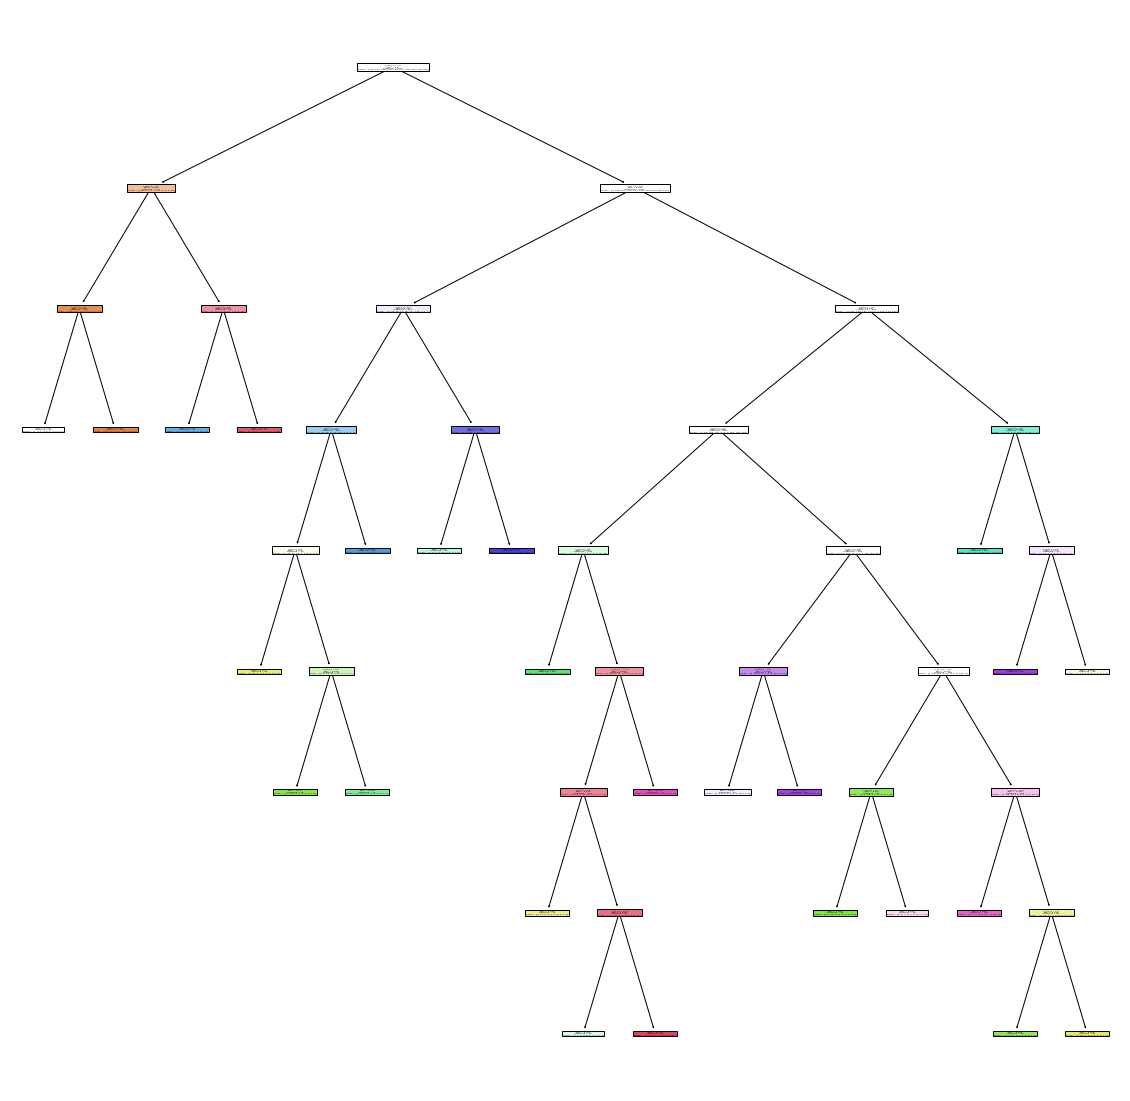

In [106]:
s = time.time()
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[max_index_auroc])
clf.fit(train_x, train_y)
e = time.time()
print(e-s)

plt.figure(figsize=(20,20))
tree.plot_tree(clf,filled=True)
plt.show()

In [107]:
clf

DecisionTreeClassifier(ccp_alpha=0.00807525454888621, random_state=0)

/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



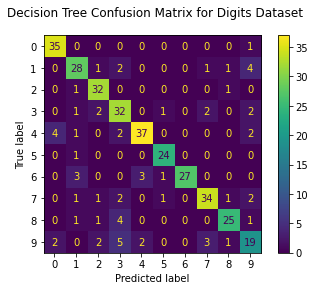

In [199]:
fig = plot_confusion_matrix(clf, test_x, test_y, display_labels=clf.classes_)
fig.figure_.suptitle("Decision Tree Confusion Matrix for Digits Dataset")
plt.show()

# Neural Networks

In [124]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [125]:
# To train a MLP network, the data should always be scaled because it is very sensitive to it.
sc=StandardScaler()

scaler = sc.fit(train_x)
trainX_scaled = scaler.transform(train_x)
testX_scaled = scaler.transform(test_x)

In [82]:
### Create a function to fit and evaluate DT at given alphas
def evaluate_nn(train_x, train_y, test_x, test_y, hyperparameter_dic, resutls_nn):
    
    layers = hyperparameter_dic['layers']
    sizes = hyperparameter_dic['sizes']
    alphas = hyperparameter_dic['alphas']
    
    number_models = len(layers)*len(sizes)*len(alphas)
    i = len(list(resutls_nn.keys()))
    
    for number_layers in layers:
        for layer_size in sizes:
            for alpha in alphas:

                for r_i in list(results_nn.keys()):
                    if alpha == results_nn[r_i][0]:
                        if layer_size == results_nn[r_i][4]:
                            if number_layers == results_nn[r_i][3]:
                                continue

                print('Training model {} of {}...'.format(i+1, number_models))

                # Initialize model
                mlp_clf = MLPClassifier(
                    hidden_layer_sizes = [layer_size]*number_layers,
                    alpha = alpha,
                    max_iter = 2000,
                    learning_rate = 'invscaling',
                    early_stopping=True,
                    verbose = True
                )

                # Fit model
                mlp_clf.fit(train_x, train_y)

                # Evaluate performance
                train_accuracy = mlp_clf.score(train_x, train_y)
                test_accuracy = mlp_clf.score(test_x, test_y)

                # Save resutls_nn
                resutls_nn[i] = (number_layers, layer_size, alpha, train_accuracy, test_accuracy)

                # Update i
                i += 1

    return resutls_nn

In [83]:
layers = [1,2]
sizes = [16, 32, 64, 128, 256]
alphas = [1e-3, 1e-2, 0.1, 0.3] # Strength of the L2 regularization term

hyperparameters_dic = {
    'layers': layers,
    'sizes': sizes,
    'alphas': alphas
}

results_nn = {}

results_nn = evaluate_nn(trainX_scaled, train_y, testX_scaled, test_y, hyperparameters_dic, results_nn)

Training model 1 of 40...
Iteration 1, loss = 2.47527039
Validation score: 0.180556
Iteration 2, loss = 2.31974585
Validation score: 0.236111
Iteration 3, loss = 2.17768105
Validation score: 0.270833
Iteration 4, loss = 2.04686825
Validation score: 0.312500
Iteration 5, loss = 1.92697262
Validation score: 0.388889
Iteration 6, loss = 1.81533183
Validation score: 0.430556
Iteration 7, loss = 1.71336671
Validation score: 0.506944
Iteration 8, loss = 1.61783274
Validation score: 0.534722
Iteration 9, loss = 1.52889077
Validation score: 0.576389
Iteration 10, loss = 1.44555412
Validation score: 0.597222
Iteration 11, loss = 1.36746283
Validation score: 0.604167
Iteration 12, loss = 1.29422627
Validation score: 0.638889
Iteration 13, loss = 1.22582323
Validation score: 0.666667
Iteration 14, loss = 1.16169665
Validation score: 0.687500
Iteration 15, loss = 1.10071937
Validation score: 0.715278
Iteration 16, loss = 1.04449426
Validation score: 0.729167
Iteration 17, loss = 0.99113676
Validat

Iteration 3, loss = 2.17160509
Validation score: 0.284722
Iteration 4, loss = 2.04827773
Validation score: 0.333333
Iteration 5, loss = 1.93752992
Validation score: 0.381944
Iteration 6, loss = 1.83596889
Validation score: 0.465278
Iteration 7, loss = 1.74177786
Validation score: 0.479167
Iteration 8, loss = 1.65323163
Validation score: 0.513889
Iteration 9, loss = 1.56976651
Validation score: 0.562500
Iteration 10, loss = 1.48929811
Validation score: 0.576389
Iteration 11, loss = 1.41066487
Validation score: 0.625000
Iteration 12, loss = 1.33278432
Validation score: 0.673611
Iteration 13, loss = 1.25716934
Validation score: 0.694444
Iteration 14, loss = 1.18538801
Validation score: 0.750000
Iteration 15, loss = 1.11827364
Validation score: 0.763889
Iteration 16, loss = 1.05563242
Validation score: 0.763889
Iteration 17, loss = 0.99958015
Validation score: 0.777778
Iteration 18, loss = 0.94784055
Validation score: 0.777778
Iteration 19, loss = 0.90133694
Validation score: 0.784722
Iter

Iteration 56, loss = 0.11617155
Validation score: 0.937500
Iteration 57, loss = 0.11330328
Validation score: 0.937500
Iteration 58, loss = 0.11053176
Validation score: 0.937500
Iteration 59, loss = 0.10798141
Validation score: 0.937500
Iteration 60, loss = 0.10532434
Validation score: 0.937500
Iteration 61, loss = 0.10288798
Validation score: 0.937500
Iteration 62, loss = 0.10065251
Validation score: 0.937500
Iteration 63, loss = 0.09833312
Validation score: 0.944444
Iteration 64, loss = 0.09603960
Validation score: 0.944444
Iteration 65, loss = 0.09402063
Validation score: 0.944444
Iteration 66, loss = 0.09193980
Validation score: 0.944444
Iteration 67, loss = 0.08990666
Validation score: 0.951389
Iteration 68, loss = 0.08784945
Validation score: 0.951389
Iteration 69, loss = 0.08600589
Validation score: 0.951389
Iteration 70, loss = 0.08420131
Validation score: 0.951389
Iteration 71, loss = 0.08239997
Validation score: 0.951389
Iteration 72, loss = 0.08069762
Validation score: 0.9513

Iteration 48, loss = 0.21314490
Validation score: 0.965278
Iteration 49, loss = 0.20928645
Validation score: 0.965278
Iteration 50, loss = 0.20589174
Validation score: 0.965278
Iteration 51, loss = 0.20242064
Validation score: 0.965278
Iteration 52, loss = 0.19904839
Validation score: 0.965278
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 9 of 40...
Iteration 1, loss = 2.67873339
Validation score: 0.131944
Iteration 2, loss = 2.26528496
Validation score: 0.312500
Iteration 3, loss = 1.90695853
Validation score: 0.444444
Iteration 4, loss = 1.60488309
Validation score: 0.541667
Iteration 5, loss = 1.35657709
Validation score: 0.645833
Iteration 6, loss = 1.15665268
Validation score: 0.729167
Iteration 7, loss = 0.99448452
Validation score: 0.770833
Iteration 8, loss = 0.86241401
Validation score: 0.805556
Iteration 9, loss = 0.75539578
Validation score: 0.805556
Iteration 10, loss = 0.66720596
Validation score: 0.819444
Itera

Iteration 17, loss = 0.39356809
Validation score: 0.916667
Iteration 18, loss = 0.37041959
Validation score: 0.923611
Iteration 19, loss = 0.34995879
Validation score: 0.923611
Iteration 20, loss = 0.33232559
Validation score: 0.923611
Iteration 21, loss = 0.31622362
Validation score: 0.930556
Iteration 22, loss = 0.30218602
Validation score: 0.937500
Iteration 23, loss = 0.28990459
Validation score: 0.944444
Iteration 24, loss = 0.27853409
Validation score: 0.944444
Iteration 25, loss = 0.26813832
Validation score: 0.944444
Iteration 26, loss = 0.25884927
Validation score: 0.944444
Iteration 27, loss = 0.25037054
Validation score: 0.951389
Iteration 28, loss = 0.24255631
Validation score: 0.951389
Iteration 29, loss = 0.23555241
Validation score: 0.951389
Iteration 30, loss = 0.22903570
Validation score: 0.958333
Iteration 31, loss = 0.22292294
Validation score: 0.958333
Iteration 32, loss = 0.21719461
Validation score: 0.965278
Iteration 33, loss = 0.21202254
Validation score: 0.9652

Iteration 47, loss = 0.07376965
Validation score: 0.944444
Iteration 48, loss = 0.07257568
Validation score: 0.944444
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 16 of 40...
Iteration 1, loss = 2.38678900
Validation score: 0.270833
Iteration 2, loss = 1.85078595
Validation score: 0.569444
Iteration 3, loss = 1.43636180
Validation score: 0.715278
Iteration 4, loss = 1.13194245
Validation score: 0.784722
Iteration 5, loss = 0.91590454
Validation score: 0.819444
Iteration 6, loss = 0.75889612
Validation score: 0.861111
Iteration 7, loss = 0.64502741
Validation score: 0.881944
Iteration 8, loss = 0.55984799
Validation score: 0.888889
Iteration 9, loss = 0.49516387
Validation score: 0.902778
Iteration 10, loss = 0.44550539
Validation score: 0.909722
Iteration 11, loss = 0.40596616
Validation score: 0.930556
Iteration 12, loss = 0.37417481
Validation score: 0.944444
Iteration 13, loss = 0.34728863
Validation score: 0.937500
Iter

Iteration 24, loss = 0.17425755
Validation score: 0.965278
Iteration 25, loss = 0.17039936
Validation score: 0.965278
Iteration 26, loss = 0.16687576
Validation score: 0.965278
Iteration 27, loss = 0.16366014
Validation score: 0.965278
Iteration 28, loss = 0.16063331
Validation score: 0.965278
Iteration 29, loss = 0.15785160
Validation score: 0.965278
Iteration 30, loss = 0.15517529
Validation score: 0.965278
Iteration 31, loss = 0.15268559
Validation score: 0.965278
Iteration 32, loss = 0.15046259
Validation score: 0.965278
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 21 of 40...
Iteration 1, loss = 2.61563900
Validation score: 0.138889
Iteration 2, loss = 2.49016926
Validation score: 0.138889
Iteration 3, loss = 2.38350147
Validation score: 0.159722
Iteration 4, loss = 2.28842040
Validation score: 0.180556
Iteration 5, loss = 2.19882715
Validation score: 0.187500
Iteration 6, loss = 2.11107709
Validation score: 0.243056
I

Iteration 30, loss = 0.47414123
Validation score: 0.868056
Iteration 31, loss = 0.44543257
Validation score: 0.868056
Iteration 32, loss = 0.41894936
Validation score: 0.875000
Iteration 33, loss = 0.39346137
Validation score: 0.895833
Iteration 34, loss = 0.37094360
Validation score: 0.909722
Iteration 35, loss = 0.34984123
Validation score: 0.909722
Iteration 36, loss = 0.33056545
Validation score: 0.916667
Iteration 37, loss = 0.31329233
Validation score: 0.916667
Iteration 38, loss = 0.29725206
Validation score: 0.916667
Iteration 39, loss = 0.28279803
Validation score: 0.923611
Iteration 40, loss = 0.26901598
Validation score: 0.930556
Iteration 41, loss = 0.25697332
Validation score: 0.930556
Iteration 42, loss = 0.24572538
Validation score: 0.930556
Iteration 43, loss = 0.23547707
Validation score: 0.930556
Iteration 44, loss = 0.22645497
Validation score: 0.937500
Iteration 45, loss = 0.21772128
Validation score: 0.937500
Iteration 46, loss = 0.21033911
Validation score: 0.9375

Iteration 41, loss = 0.07269376
Validation score: 0.937500
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 26 of 40...
Iteration 1, loss = 2.35664809
Validation score: 0.270833
Iteration 2, loss = 2.13582913
Validation score: 0.375000
Iteration 3, loss = 1.94993692
Validation score: 0.465278
Iteration 4, loss = 1.78256600
Validation score: 0.534722
Iteration 5, loss = 1.62421171
Validation score: 0.611111
Iteration 6, loss = 1.47183321
Validation score: 0.687500
Iteration 7, loss = 1.32205170
Validation score: 0.701389
Iteration 8, loss = 1.17840729
Validation score: 0.743056
Iteration 9, loss = 1.04044820
Validation score: 0.756944
Iteration 10, loss = 0.91112312
Validation score: 0.791667
Iteration 11, loss = 0.79396864
Validation score: 0.791667
Iteration 12, loss = 0.68784048
Validation score: 0.798611
Iteration 13, loss = 0.59779294
Validation score: 0.812500
Iteration 14, loss = 0.52061658
Validation score: 0.826389
Iter

Iteration 42, loss = 0.16996595
Validation score: 0.930556
Iteration 43, loss = 0.16670064
Validation score: 0.923611
Iteration 44, loss = 0.16374156
Validation score: 0.923611
Iteration 45, loss = 0.16088434
Validation score: 0.923611
Iteration 46, loss = 0.15823002
Validation score: 0.923611
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 29 of 40...
Iteration 1, loss = 2.36193139
Validation score: 0.305556
Iteration 2, loss = 2.01663275
Validation score: 0.520833
Iteration 3, loss = 1.73776439
Validation score: 0.666667
Iteration 4, loss = 1.48076891
Validation score: 0.756944
Iteration 5, loss = 1.23466854
Validation score: 0.784722
Iteration 6, loss = 1.00715800
Validation score: 0.833333
Iteration 7, loss = 0.80774225
Validation score: 0.854167
Iteration 8, loss = 0.64794116
Validation score: 0.875000
Iteration 9, loss = 0.52279434
Validation score: 0.888889
Iteration 10, loss = 0.42619439
Validation score: 0.902778
Iter

Iteration 7, loss = 0.84166244
Validation score: 0.902778
Iteration 8, loss = 0.68515284
Validation score: 0.916667
Iteration 9, loss = 0.56710813
Validation score: 0.916667
Iteration 10, loss = 0.48426481
Validation score: 0.930556
Iteration 11, loss = 0.42270603
Validation score: 0.937500
Iteration 12, loss = 0.37800799
Validation score: 0.944444
Iteration 13, loss = 0.34384801
Validation score: 0.951389
Iteration 14, loss = 0.31763463
Validation score: 0.951389
Iteration 15, loss = 0.29722606
Validation score: 0.951389
Iteration 16, loss = 0.28036568
Validation score: 0.958333
Iteration 17, loss = 0.26554404
Validation score: 0.958333
Iteration 18, loss = 0.25335706
Validation score: 0.958333
Iteration 19, loss = 0.24280029
Validation score: 0.958333
Iteration 20, loss = 0.23335790
Validation score: 0.965278
Iteration 21, loss = 0.22526492
Validation score: 0.972222
Iteration 22, loss = 0.21819710
Validation score: 0.979167
Iteration 23, loss = 0.21138997
Validation score: 0.979167


Iteration 9, loss = 0.04905251
Validation score: 0.958333
Iteration 10, loss = 0.04041176
Validation score: 0.958333
Iteration 11, loss = 0.03292865
Validation score: 0.951389
Iteration 12, loss = 0.02712073
Validation score: 0.951389
Iteration 13, loss = 0.02325483
Validation score: 0.951389
Iteration 14, loss = 0.02012228
Validation score: 0.951389
Iteration 15, loss = 0.01744231
Validation score: 0.958333
Iteration 16, loss = 0.01536007
Validation score: 0.958333
Iteration 17, loss = 0.01375547
Validation score: 0.958333
Iteration 18, loss = 0.01218284
Validation score: 0.958333
Iteration 19, loss = 0.01109687
Validation score: 0.958333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 38 of 40...
Iteration 1, loss = 1.92202672
Validation score: 0.840278
Iteration 2, loss = 0.99435039
Validation score: 0.923611
Iteration 3, loss = 0.50014717
Validation score: 0.937500
Iteration 4, loss = 0.28221925
Validation score: 0.958333


In [84]:
layer_list = [results_nn[i][0] for i in list(results_nn.keys())]
size_list = [results_nn[i][1] for i in list(results_nn.keys())]
alpha_list = [results_nn[i][2] for i in list(results_nn.keys())]
train_acc_list = [results_nn[i][3]*100 for i in list(results_nn.keys())]
test_acc_list = [results_nn[i][4]*100 for i in list(results_nn.keys())]

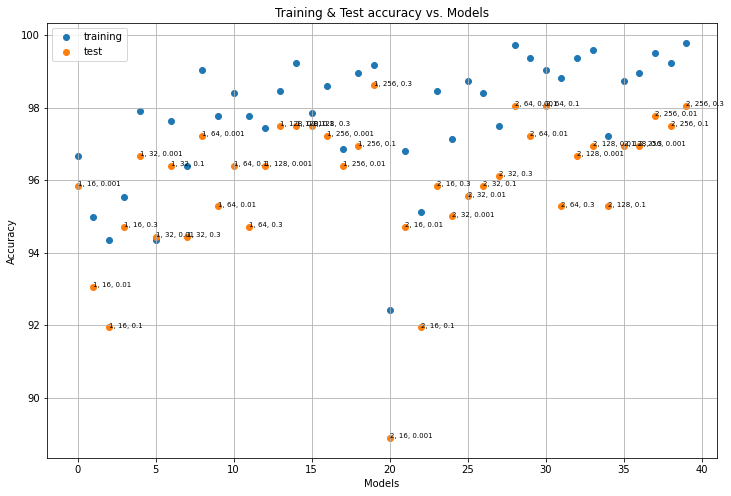

In [85]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(list(results_nn.keys()), train_acc_list, label="training")
plt.scatter(list(results_nn.keys()), test_acc_list, label="test")
plt.title("Training & Test accuracy vs. Models")
plt.legend()
plt.xlabel('Models')
plt.ylabel('Accuracy')
for i in (list(results_nn.keys())):
    ax.text(i, test_acc_list[i], str(results_nn[i][0])+', '+str(results_nn[i][1])+', '+str(results_nn[i][2]), size=7)
plt.grid()
plt.show()

In [86]:
max_index = np.argmax(test_acc_list)
print(max_index)
print('layer: ' + str(layer_list[max_index]))
print('size: ' + str(size_list[max_index]))
print('alpha: ' + str(alpha_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

19
layer: 1
size: 256
alpha: 0.3
Training accuracy: 99.16493%
Test accuracy: 98.61111%


In [126]:
s=time.time()
mlp = MLPClassifier(
                    hidden_layer_sizes = [256],
                    alpha = 0.0001,
                    max_iter = 1500,
                    learning_rate = 'invscaling',
                    verbose = True
                )

# Fit model
mlp.fit(trainX_scaled, train_y)
e=time.time()
print(e-s)

Iteration 1, loss = 2.03485795
Iteration 2, loss = 1.31275275
Iteration 3, loss = 0.88306239
Iteration 4, loss = 0.62969024
Iteration 5, loss = 0.46964912
Iteration 6, loss = 0.36690874
Iteration 7, loss = 0.29966011
Iteration 8, loss = 0.25203419
Iteration 9, loss = 0.21487812
Iteration 10, loss = 0.18770903
Iteration 11, loss = 0.16616764
Iteration 12, loss = 0.14828430
Iteration 13, loss = 0.13324372
Iteration 14, loss = 0.12070234
Iteration 15, loss = 0.11012182
Iteration 16, loss = 0.10065310
Iteration 17, loss = 0.09261049
Iteration 18, loss = 0.08553628
Iteration 19, loss = 0.07925512
Iteration 20, loss = 0.07356470
Iteration 21, loss = 0.06825191
Iteration 22, loss = 0.06372330
Iteration 23, loss = 0.05936772
Iteration 24, loss = 0.05559146
Iteration 25, loss = 0.05204424
Iteration 26, loss = 0.04890643
Iteration 27, loss = 0.04603861
Iteration 28, loss = 0.04337183
Iteration 29, loss = 0.04070152
Iteration 30, loss = 0.03840529
Iteration 31, loss = 0.03633619
Iteration 32, los

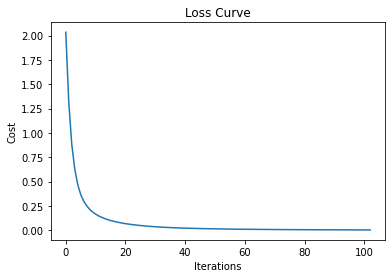

In [127]:
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [87]:
mlp = MLPClassifier(
                    hidden_layer_sizes = [256],
                    alpha = 0.3,
                    max_iter = 10,
                    learning_rate = 'invscaling',
                    verbose = True
                )

# Fit model
#mlp_clf.fit(trainX_scaled, train_y)

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = trainX_scaled.shape[0]
N_EPOCHS = 25
N_BATCH = 128
N_CLASSES = np.unique(train_y)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(trainX_scaled.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(trainX_scaled[indices], train_y[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(mlp.score(trainX_scaled, train_y))

    # SCORE TEST
    scores_test.append(mlp.score(testX_scaled, test_y))

    epoch += 1



epoch:  0
Iteration 1, loss = 2.64940208
Iteration 2, loss = 2.58447445
Iteration 3, loss = 2.40952132
Iteration 4, loss = 2.35820144
Iteration 5, loss = 2.17818563
Iteration 6, loss = 2.13545665
Iteration 7, loss = 2.02150007
Iteration 8, loss = 1.96687244
Iteration 9, loss = 1.76055168
Iteration 10, loss = 1.79334963
Iteration 11, loss = 1.62801179
Iteration 12, loss = 2.15186413
epoch:  1
Iteration 13, loss = 1.48726545
Iteration 14, loss = 1.43040556
Iteration 15, loss = 1.37979849
Iteration 16, loss = 1.27005730
Iteration 17, loss = 1.25697190
Iteration 18, loss = 1.16003337
Iteration 19, loss = 1.14454800
Iteration 20, loss = 1.08247575
Iteration 21, loss = 1.00483624
Iteration 22, loss = 1.08369370
Iteration 23, loss = 1.01083993
Iteration 24, loss = 1.45678756
epoch:  2
Iteration 25, loss = 0.84041038
Iteration 26, loss = 1.00327516
Iteration 27, loss = 0.84449115
Iteration 28, loss = 0.73706612
Iteration 29, loss = 0.79394096
Iteration 30, loss = 0.84936382
Iteration 31, loss 

Iteration 196, loss = 0.18401117
Iteration 197, loss = 0.18953800
Iteration 198, loss = 0.20544213
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 199, loss = 0.21409750
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 200, loss = 0.19903363
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 201, loss = 0.22451735
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 202, loss = 0.24072664
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 203, loss = 0.21910662
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 204, loss = 0.68282000
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
epoch:  17
Iteration 205, loss = 0.20007337
Training loss did not improve

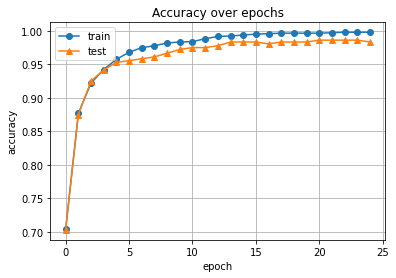

In [88]:
""" Plot """
#fig, ax = plt.subplots(2, sharex=True, sharey=True)
plt.plot(range(N_EPOCHS), scores_train, 'o-',label='train')
plt.plot(range(N_EPOCHS), scores_test, '^-',label='test')
plt.title("Accuracy over epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



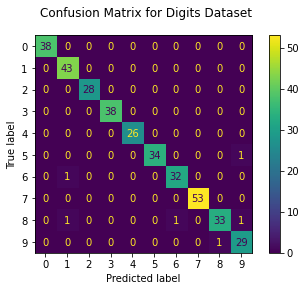

In [89]:
fig = plot_confusion_matrix(mlp, testX_scaled, test_y, display_labels=mlp.classes_)
fig.figure_.suptitle("Confusion Matrix for Digits Dataset")
plt.show()

# Gradient Boosting
Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. It strongly relies on the prediction that the next model will reduce prediction errors when blended with previous ones. The main idea is to establish target outcomes for this upcoming model to minimize errors.

Gradient Boosting trains many models in a gradual, additive and sequential manner. The term gradient boosting emerged because every case’s target outcomes are based on the gradient’s error with regards to the predictions. Every model reduces prediction errors by taking a step in the correct direction.

In [108]:
from sklearn.ensemble import GradientBoostingClassifier

In [109]:
# --- Applying Gradient Boosting ---

GBclassifier = GradientBoostingClassifier(random_state=1, n_estimators=100, max_leaf_nodes=3, 
                                          loss='deviance', 
                                          min_samples_leaf=20)

GBclassifier.fit(train_x, train_y)
y_pred_GB = GBclassifier.predict(test_x)

# --- Gradient Boosting Accuracy ---
GBAcc = accuracy_score(y_pred_GB, test_y)
print('.:. Gradient Boosting Accuracy:'+'\033[1m {:.2f}%'.format(GBAcc*100)+' .:.')

.:. Gradient Boosting Accuracy: 95.00% .:.


In [110]:
def evaluate_gbc(train_x, train_y, test_x, test_y, hyperparameters_dic, results_gbc):
    
    lrs = hyperparameters_dic['lrs']
    estimators = hyperparameters_dic['estimators']
    
    i = len(list(results_gbc.keys()))
    
    n_models = len(lrs)*len(estimators)
    
    for lr in lrs:
        for n in estimators:
            
            print('Training model {} of {}...'.format(i+1, n_models))
            
            for r_i in list(results_gbc.keys()):
                if lr == results_gbc[r_i][0]:
                    if n == results_gbc[r_i][1]:
                        continue
                        

            results_gbc[i] = []

            model = GradientBoostingClassifier(learning_rate = lr, n_estimators=n)

            model.fit(train_x, train_y)

            train_accuracy = model.score(train_x, train_y)
            test_accuracy = model.score(test_x, test_y)

            results_gbc[i].append(lr)
            results_gbc[i].append(n)
            results_gbc[i].append(train_accuracy)
            results_gbc[i].append(test_accuracy)

            i += 1

    return results_gbc

In [111]:
lrs = [0.5, 0.3, 0.1, 1e-2, 1e-3, 1e-4]
#alphas = [1e-2, 1e-3, 1e-4, 1e-5, 5e-5, 1e-6]
estimators = [100, 200, 300, 500, 800, 1000]

hyperparameters_dic = {'lrs': lrs,  "estimators":estimators}

results_gbc = evaluate_gbc(train_x, train_y, test_x, test_y, hyperparameters_dic, {})

Training model 1 of 36...
Training model 2 of 36...
Training model 3 of 36...
Training model 4 of 36...
Training model 5 of 36...
Training model 6 of 36...
Training model 7 of 36...
Training model 8 of 36...
Training model 9 of 36...
Training model 10 of 36...
Training model 11 of 36...
Training model 12 of 36...
Training model 13 of 36...
Training model 14 of 36...
Training model 15 of 36...
Training model 16 of 36...
Training model 17 of 36...
Training model 18 of 36...
Training model 19 of 36...
Training model 20 of 36...
Training model 21 of 36...
Training model 22 of 36...
Training model 23 of 36...
Training model 24 of 36...
Training model 25 of 36...
Training model 26 of 36...
Training model 27 of 36...
Training model 28 of 36...
Training model 29 of 36...
Training model 30 of 36...
Training model 31 of 36...
Training model 32 of 36...
Training model 33 of 36...
Training model 34 of 36...
Training model 35 of 36...
Training model 36 of 36...


In [112]:
for key in results_gbc.keys():
    print('Alphas: ' + str(results_gbc[key][0]))
    print('# weak leaners: ' + str(results_gbc[key][1]))
    print('Training accuracy: ' + str(results_gbc[key][2]))
    print('Test accuracy: ' + str(results_gbc[key][3]))
    print()

Alphas: 0.5
# weak leaners: 100
Training accuracy: 1.0
Test accuracy: 0.9527777777777777

Alphas: 0.5
# weak leaners: 200
Training accuracy: 1.0
Test accuracy: 0.9527777777777777

Alphas: 0.5
# weak leaners: 300
Training accuracy: 1.0
Test accuracy: 0.9527777777777777

Alphas: 0.5
# weak leaners: 500
Training accuracy: 1.0
Test accuracy: 0.9527777777777777

Alphas: 0.5
# weak leaners: 800
Training accuracy: 1.0
Test accuracy: 0.9527777777777777

Alphas: 0.5
# weak leaners: 1000
Training accuracy: 1.0
Test accuracy: 0.9527777777777777

Alphas: 0.3
# weak leaners: 100
Training accuracy: 1.0
Test accuracy: 0.9583333333333334

Alphas: 0.3
# weak leaners: 200
Training accuracy: 1.0
Test accuracy: 0.9583333333333334

Alphas: 0.3
# weak leaners: 300
Training accuracy: 1.0
Test accuracy: 0.9583333333333334

Alphas: 0.3
# weak leaners: 500
Training accuracy: 1.0
Test accuracy: 0.9583333333333334

Alphas: 0.3
# weak leaners: 800
Training accuracy: 1.0
Test accuracy: 0.9583333333333334

Alphas: 0

In [113]:
save_results(results_gbc, 'results_gbc')
results_gbc = load_results('results_gbc.json')

In [114]:
alpha_list = [results_gbc[i][0] for i in list(results_gbc.keys())]
n_list = [results_gbc[i][1]*100 for i in list(results_gbc.keys())]
train_acc_list = [results_gbc[i][2]*100 for i in list(results_gbc.keys())]
test_acc_list = [results_gbc[i][3]*100 for i in list(results_gbc.keys())]

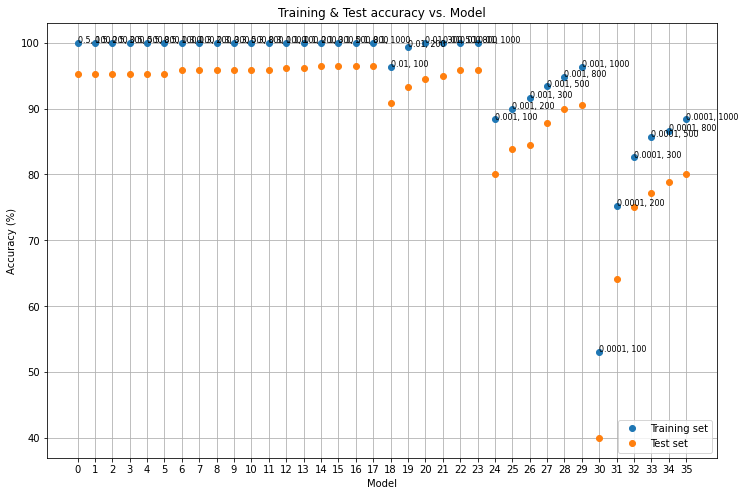

In [115]:
lr_list = [results_gbc[i][0] for i in list(results_gbc.keys())]
n_list = [results_gbc[i][1] for i in list(results_gbc.keys())]
train_acc_list = [results_gbc[i][2]*100 for i in list(results_gbc.keys())]
test_acc_list = [results_gbc[i][3]*100 for i in list(results_gbc.keys())]

#alpha_list, train_acc_list, test_acc_list = zip(*sorted(zip(alpha_list, train_acc_list, test_acc_list)))

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(list(results_gbc.keys()), train_acc_list, 'o', label='Training set')
plt.plot(list(results_gbc.keys()), test_acc_list, 'o', label='Test set')
plt.title("Training & Test accuracy vs. Model")
plt.legend(loc="lower right")
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
for i in (list(results_gbc.keys())):
    ax.text(i, train_acc_list[int(i)], str(results_gbc[i][0])+', '+str(results_gbc[i][1]), size=8)

plt.grid()
plt.show()

In [116]:
max_index = np.argmax(test_acc_list)
print(max_index)
print('lr: ' + str(lr_list[max_index]))
print('n_estimator: ' + str(n_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

14
lr: 0.1
n_estimator: 300
Training accuracy: 100.0%
Test accuracy: 96.38889%


In [117]:
s = time.time()
gbc_clf =GradientBoostingClassifier(learning_rate = 0.5, n_estimators=300)

gbc_clf.fit(train_x, train_y)
e = time.time()
print(e-s)

# train_accuracy = gbc_clf.score(train_x, train_y)
# test_accuracy = gbc_clf.score(test_x, test_y)

3.442034959793091


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



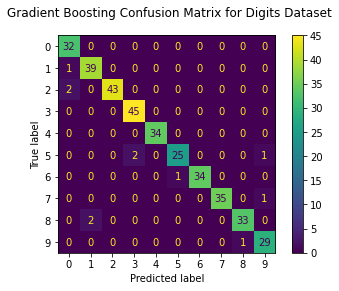

In [34]:
from sklearn.metrics import plot_confusion_matrix
fig = plot_confusion_matrix(gbc_clf, test_x, test_y, display_labels=gbc_clf.classes_)
fig.figure_.suptitle("Gradient Boosting Confusion Matrix for Digits Dataset")
plt.show()

# SVM
Support Vector Machine (SVM) is one of the most popular Supervised Learning algorithms, which is used for Classification as well as Regression problems.

The goal of the SVM algorithm is to create the best line or decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future. This best decision boundary is called a hyperplane.

SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors, and hence algorithm is termed as Support Vector Machine.

In [118]:
# --- Applying SVM ---
from sklearn.svm import SVC
SVMclassifier = SVC(kernel='linear', C=10, probability=True)
SVMclassifier.fit(train_x, train_y)

y_pred_SVM = SVMclassifier.predict(test_x)

# --- SVM Accuracy ---
SVMAcc = accuracy_score(y_pred_SVM, test_y)
print('.:. Support Vector Machine Accuracy:'+'\033[1m {:.2f}%'.format(SVMAcc*100)+' .:.')

.:. Support Vector Machine Accuracy: 98.33% .:.


In [13]:
def evaluate_svm(train_x, train_y, test_x, test_y, hyperparameters_dic, results_svm):
    
    cs = hyperparameters_dic['cs']
    kernels = hyperparameters_dic['kernels']
    
    i = len(list(results_svm.keys()))
    
    n_models = len(cs)*len(kernels)
    
    for kernel in kernels:
        for c in cs:
            
            print('Training model {} of {}...'.format(i+1, n_models))
            
            for r_i in list(results_svm.keys()):
                if c == results_svm[r_i][0]:
                    if kernel == results_svm[r_i][1]:
                        continue

            results_svm[i] = []

            svc_model = SVC(C = c, kernel=kernel)

            svc_model.fit(train_x, train_y)

            train_accuracy = svc_model.score(train_x, train_y)
            test_accuracy = svc_model.score(test_x, test_y)

            results_svm[i].append(c)
            results_svm[i].append(kernel)
            results_svm[i].append(train_accuracy)
            results_svm[i].append(test_accuracy)

            i += 1

    return results_svm

In [14]:
cs = [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 100, 500, 1000, 10000]
kernels = ['linear', 'rbf']

hyperparameters_dic = {'cs': cs, 'kernels': kernels}

results_svm = evaluate_svm(train_x, train_y, test_x, test_y, hyperparameters_dic, {})

Training model 1 of 20...
Training model 2 of 20...
Training model 3 of 20...
Training model 4 of 20...
Training model 5 of 20...
Training model 6 of 20...
Training model 7 of 20...
Training model 8 of 20...
Training model 9 of 20...
Training model 10 of 20...
Training model 11 of 20...
Training model 12 of 20...
Training model 13 of 20...
Training model 14 of 20...
Training model 15 of 20...
Training model 16 of 20...
Training model 17 of 20...
Training model 18 of 20...
Training model 19 of 20...
Training model 20 of 20...


In [15]:
for key in results_svm.keys():
    print('Alphas: ' + str(results_svm[key][0]))
    print('Kernal: ' + str(results_svm[key][1]))
    print('Training accuracy: ' + str(results_svm[key][2]))
    print('Test accuracy: ' + str(results_svm[key][3]))
    print()

Alphas: 1e-05
Kernal: linear
Training accuracy: 0.7780097425191371
Test accuracy: 0.775

Alphas: 0.0001
Kernal: linear
Training accuracy: 0.9631176061238692
Test accuracy: 0.9722222222222222

Alphas: 0.001
Kernal: linear
Training accuracy: 0.9916492693110647
Test accuracy: 0.9833333333333333

Alphas: 0.01
Kernal: linear
Training accuracy: 1.0
Test accuracy: 0.9833333333333333

Alphas: 0.1
Kernal: linear
Training accuracy: 1.0
Test accuracy: 0.9833333333333333

Alphas: 1
Kernal: linear
Training accuracy: 1.0
Test accuracy: 0.9833333333333333

Alphas: 100
Kernal: linear
Training accuracy: 1.0
Test accuracy: 0.9833333333333333

Alphas: 500
Kernal: linear
Training accuracy: 1.0
Test accuracy: 0.9833333333333333

Alphas: 1000
Kernal: linear
Training accuracy: 1.0
Test accuracy: 0.9833333333333333

Alphas: 10000
Kernal: linear
Training accuracy: 1.0
Test accuracy: 0.9833333333333333

Alphas: 1e-05
Kernal: rbf
Training accuracy: 0.10786360473208072
Test accuracy: 0.07222222222222222

Alphas: 

In [16]:
save_results(results_svm, 'results_svm')

In [17]:
results_svm

{0: [1e-05, 'linear', 0.7780097425191371, 0.775],
 1: [0.0001, 'linear', 0.9631176061238692, 0.9722222222222222],
 2: [0.001, 'linear', 0.9916492693110647, 0.9833333333333333],
 3: [0.01, 'linear', 1.0, 0.9833333333333333],
 4: [0.1, 'linear', 1.0, 0.9833333333333333],
 5: [1, 'linear', 1.0, 0.9833333333333333],
 6: [100, 'linear', 1.0, 0.9833333333333333],
 7: [500, 'linear', 1.0, 0.9833333333333333],
 8: [1000, 'linear', 1.0, 0.9833333333333333],
 9: [10000, 'linear', 1.0, 0.9833333333333333],
 10: [1e-05, 'rbf', 0.10786360473208072, 0.07222222222222222],
 11: [0.0001, 'rbf', 0.10786360473208072, 0.07222222222222222],
 12: [0.001, 'rbf', 0.10786360473208072, 0.07222222222222222],
 13: [0.01, 'rbf', 0.23382045929018788, 0.175],
 14: [0.1, 'rbf', 0.9631176061238692, 0.9583333333333334],
 15: [1, 'rbf', 0.9965205288796103, 0.9861111111111112],
 16: [100, 'rbf', 1.0, 0.9944444444444445],
 17: [500, 'rbf', 1.0, 0.9944444444444445],
 18: [1000, 'rbf', 1.0, 0.9944444444444445],
 19: [10000,

In [18]:
results_svm = load_results('results_svm.json')

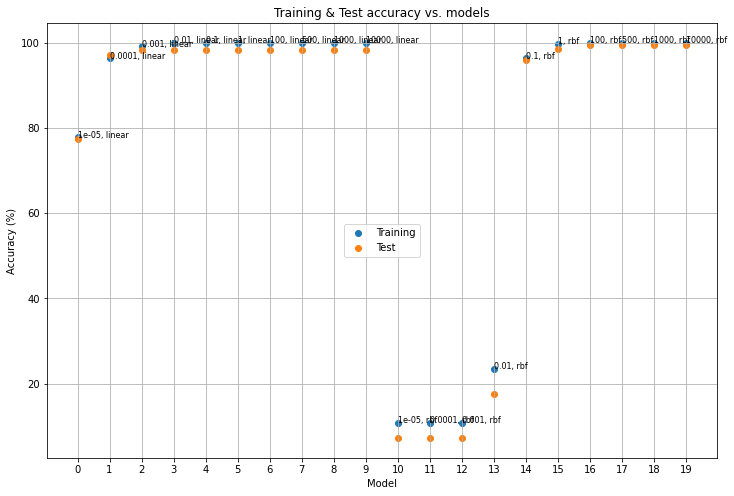

In [32]:
C_list = [results_svm[i][0] for i in list(results_svm.keys())]
kernel_list = [results_svm[i][1] for i in list(results_svm.keys())]
train_acc_list = [results_svm[i][2]*100 for i in list(results_svm.keys())]
test_acc_list = [results_svm[i][3]*100 for i in list(results_svm.keys())]

#alpha_list, train_acc_list, test_acc_list = zip(*sorted(zip(alpha_list, train_acc_list, test_acc_list)))
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(list(results_svm.keys()), train_acc_list, label='Training')
plt.scatter(list(results_svm.keys()), test_acc_list, label='Test')
plt.title("Training & Test accuracy vs. models")
plt.legend(loc='center')
plt.grid()
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
for i in (list(results_svm.keys())):
    ax.text(i, train_acc_list[int(i)], str(results_svm[i][0])+', '+results_svm[i][1], size=8)
plt.show()


In [33]:
max_index = np.argmax(test_acc_list)
print(max_index)
print('C: ' + str(C_list[max_index]))
print('Kernel: ' + str(kernel_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

16
C: 100
Kernel: rbf
Training accuracy: 100.0%
Test accuracy: 99.44444%


In [120]:
s = time.time()
svm_clf =SVC(C = 100, kernel='rbf')

svm_clf.fit(train_x, train_y)
e = time.time()
print(e-s)

0.021015644073486328


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



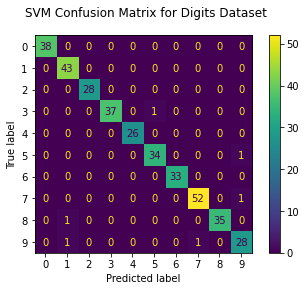

In [31]:
from sklearn.metrics import plot_confusion_matrix
fig = plot_confusion_matrix(svm_clf, test_x, test_y, display_labels=svm_clf.classes_)
fig.figure_.suptitle("SVM Confusion Matrix for Digits Dataset")
plt.show()

# KNN

The k-nearest neighbors (KNN) algorithm is a data classification method for estimating the likelihood that a data point will become a member of one group or another based on what group the data points nearest to it belong to.

The k-nearest neighbor algorithm is a type of supervised machine learning algorithm used to solve classification and regression problems.

It's called a lazy learning algorithm or lazy learner because it doesn't perform any training when you supply the training data. Instead, it just stores the data during the training time and doesn't perform any calculations. It doesn't build a model until a query is performed on the dataset. This makes KNN ideal for data mining..

In [121]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy: 0.975


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



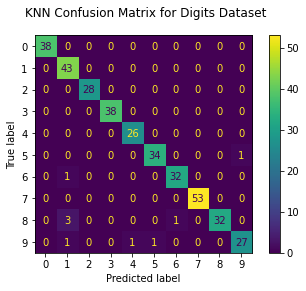

In [122]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(train_x, train_y)
y_pred_knn = knn.predict(test_x)
y_pred_prob_knn = knn.predict_proba(test_x)[:, 1]

print('Accuracy:', accuracy_score(test_y, y_pred_knn))

fig = plot_confusion_matrix(knn, test_x, test_y, display_labels=knn.classes_)
fig.figure_.suptitle("KNN Confusion Matrix for Digits Dataset")
plt.show()

In [37]:
def evaluate_knn(train_x, train_y, test_x, test_y, hyperparameters_dic, results_knn):
    
    neighbors_list = hyperparameters_dic['neighbors_list']
    weights_list = hyperparameters_dic['weights_list']
    
    i = len(list(results_knn.keys()))
    
    n_models = len(neighbors_list)*len(weights_list)
    
    for weights in weights_list:
        for neighbors in neighbors_list:
            
            print('Training model {} of {}...'.format(i+1, n_models))
            
            for r_i in list(results_knn.keys()):
                if neighbors == results_knn[r_i][0]:
                    if weights == results_knn[r_i][1]:
                        continue
            
            results_knn[i] = []
            
            model = KNeighborsClassifier(n_neighbors=neighbors, weights=weights)
            
            model.fit(train_x, train_y)
            
            train_accuracy = model.score(train_x, train_y)
            test_accuracy = model.score(test_x, test_y)
            
            results_knn[i].append(neighbors)
            results_knn[i].append(weights)
            results_knn[i].append(train_accuracy)
            results_knn[i].append(test_accuracy)
            
            i += 1
            
    return results_knn

In [39]:
neighbors_list = list(range(2, 21))
print(neighbors_list)
weights_list = ['uniform', 'distance']
hyperparameter_dic = {'neighbors_list': neighbors_list, 'weights_list': weights_list}

results_knn = evaluate_knn(train_x, train_y, test_x, test_y, hyperparameter_dic, {})

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Training model 1 of 38...
Training model 2 of 38...
Training model 3 of 38...
Training model 4 of 38...
Training model 5 of 38...
Training model 6 of 38...
Training model 7 of 38...
Training model 8 of 38...
Training model 9 of 38...
Training model 10 of 38...
Training model 11 of 38...
Training model 12 of 38...
Training model 13 of 38...
Training model 14 of 38...
Training model 15 of 38...
Training model 16 of 38...
Training model 17 of 38...
Training model 18 of 38...
Training model 19 of 38...
Training model 20 of 38...
Training model 21 of 38...
Training model 22 of 38...
Training model 23 of 38...
Training model 24 of 38...
Training model 25 of 38...
Training model 26 of 38...
Training model 27 of 38...
Training model 28 of 38...
Training model 29 of 38...
Training model 30 of 38...
Training model 31 of 38...
Training model 32 of 38...
Training model 33 of 38...
Training model 34 of 38...
Training model 35 of 3

In [40]:
for key in results_knn.keys():
    print('Number nerighbors: ' + str(results_knn[key][0]))
    print('Weighting: ' + str(results_knn[key][1]))
    print('Training accuracy: ' + str(results_knn[key][2]))
    print('Test accuracy: ' + str(results_knn[key][3]))
    print()

Number nerighbors: 2
Weighting: uniform
Training accuracy: 0.9909533750869868
Test accuracy: 0.975

Number nerighbors: 3
Weighting: uniform
Training accuracy: 0.9944328462073765
Test accuracy: 0.9861111111111112

Number nerighbors: 4
Weighting: uniform
Training accuracy: 0.9923451635351427
Test accuracy: 0.9833333333333333

Number nerighbors: 5
Weighting: uniform
Training accuracy: 0.9902574808629089
Test accuracy: 0.9805555555555555

Number nerighbors: 6
Weighting: uniform
Training accuracy: 0.988169798190675
Test accuracy: 0.9805555555555555

Number nerighbors: 7
Weighting: uniform
Training accuracy: 0.988865692414753
Test accuracy: 0.9805555555555555

Number nerighbors: 8
Weighting: uniform
Training accuracy: 0.9867780097425192
Test accuracy: 0.9805555555555555

Number nerighbors: 9
Weighting: uniform
Training accuracy: 0.988169798190675
Test accuracy: 0.9805555555555555

Number nerighbors: 10
Weighting: uniform
Training accuracy: 0.9853862212943633
Test accuracy: 0.9805555555555555

In [41]:
save_results(results_knn, 'results_knn')

In [42]:
results_knn = load_results('results_knn.json')

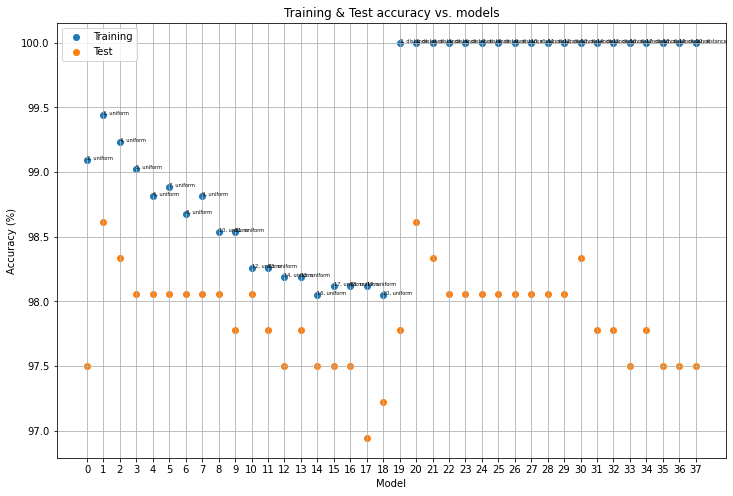

In [48]:
neighbors_list = [results_knn[i][0] for i in list(results_knn.keys())]
weights_list = [results_knn[i][1] for i in list(results_knn.keys())]
train_acc_list = [results_knn[i][2]*100 for i in list(results_knn.keys())]
test_acc_list = [results_knn[i][3]*100 for i in list(results_knn.keys())]

#c_list, train_acc_list, test_acc_list = zip(*sorted(zip(c_list, train_acc_list, test_acc_list)))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(list(results_knn.keys()), train_acc_list, label='Training')
plt.scatter(list(results_knn.keys()), test_acc_list, label='Test')
plt.legend()
plt.title("Training & Test accuracy vs. models")
plt.xlabel('Model')
plt.grid()
plt.ylabel('Accuracy (%)')
for i in (list(results_knn.keys())):
    ax.text(i, train_acc_list[int(i)], str(results_knn[i][0])+', '+results_knn[i][1], size=5)
plt.show()

In [49]:
max_index = np.argmax(test_acc_list)
print(max_index)
print('Number of Neighbors: ' + str(neighbors_list[max_index]))
print('Weighting Methond: ' + str(weights_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

1
Number of Neighbors: 3
Weighting Methond: uniform
Training accuracy: 99.44328%
Test accuracy: 98.61111%


In [123]:
s=time.time()
knn_clf =KNeighborsClassifier(n_neighbors=3, weights='uniform')

knn_clf.fit(train_x, train_y)
e = time.time()
print(e-s)

0.0022666454315185547


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



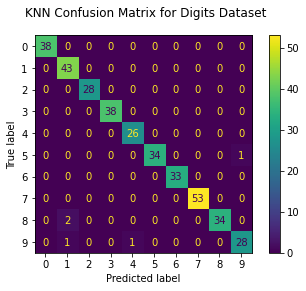

In [47]:
fig = plot_confusion_matrix(knn_clf, test_x, test_y, display_labels=knn_clf.classes_)
fig.figure_.suptitle("KNN Confusion Matrix for Digits Dataset")
plt.show()